In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import glob
from scipy.interpolate import interp1d

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
## for running on colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
data_dir = "rto_data"
data_files = glob.glob(f"{data_dir}/ercot_hourly_demand_and_price_*.csv")

years = [ii[-8:-4] for ii in data_files]

dataframes = {}
august_dataframes = {}

for year, file_path in zip(years,data_files):
    dataframes[year] = pd.read_csv(file_path)
    dataframes[year]['timestamp'] = pd.to_datetime(dataframes[year]['timestamp'], utc=True, errors='coerce').dt.tz_convert('US/Central')
    august_dataframes[year] = dataframes[year][dataframes[year]['timestamp'].dt.month == 8].copy()

avg_data_by_hour = {}

for year, df in august_dataframes.items():
    df['hour'] = df['timestamp'].dt.hour
    # Ensure 'load.load' is numeric before grouping
    df['load'] = pd.to_numeric(df['load'], errors='coerce')
    x1 = df.groupby('hour')[['load', 'net_load', 'fuel_mix.natural_gas', 'fuel_mix.solar', 'fuel_mix.wind', 'fuel_mix.power_storage', 'price']].mean().reset_index()

    ## define net_load to be total load minus solar, wind, and batteries
    x1['net_load'] = x1['load'] - x1['fuel_mix.solar'] - x1['fuel_mix.wind']- x1['fuel_mix.power_storage']
    x1 = x1.set_index('hour')
    avg_data_by_hour[year] = x1

    print(f"Average data by hour in August {year}:")
    display(avg_data_by_hour[year].head())

Average data by hour in August 2018:


,load,net_load,fuel_mix.natural_gas,fuel_mix.solar,fuel_mix.wind,fuel_mix.power_storage,price
hour,,,,,,,
0,44758.876344,34922.844659,19432.146425,0.0,9836.031685,0.0,19.951290
1,42617.206989,32996.020463,18133.536863,0.0,9621.186526,0.0,18.689032
2,41150.545699,31919.306820,17415.758017,0.0,9231.238879,0.0,17.885484
3,40385.422043,31527.757464,17111.066429,0.0,8857.664579,0.0,17.182903
4,40555.620968,32103.918636,17191.296571,0.0,8451.702332,0.0,17.271935


Average data by hour in August 2024:


,load,net_load,fuel_mix.natural_gas,fuel_mix.solar,fuel_mix.wind,fuel_mix.power_storage,price
hour,,,,,,,
0,60091.381720,43892.044624,31463.061559,0.551075,16116.800269,81.985753,20.048065
1,57336.658602,41953.216935,30057.857796,0.365860,15324.103226,58.972581,18.150000
2,55213.024194,40759.110753,29110.170968,0.361559,14400.705108,52.846774,16.955484
3,53749.314516,40358.026613,28849.690860,0.335215,13338.415323,52.537366,16.671935
4,52978.620968,40661.483602,29134.357258,0.325269,12254.664516,62.147581,16.989355


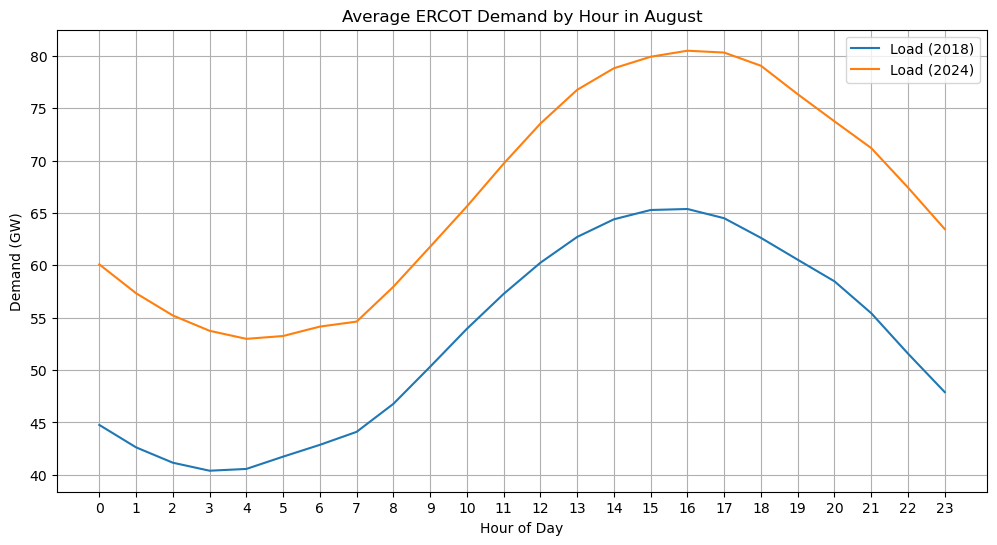

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for year, df in avg_data_by_hour.items():
    if year == '2023': continue
    # Create a new variable for load data in GW
    load_gw = df['load'] / 1e3
    sns.lineplot(data=df, x='hour', y=load_gw, label=f'Load ({year})')

plt.title('Average ERCOT Demand by Hour in August')
plt.xlabel('Hour of Day')
plt.ylabel('Demand (GW)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.savefig('ercot_demand_by_hour_august.png', dpi=300)
plt.show()

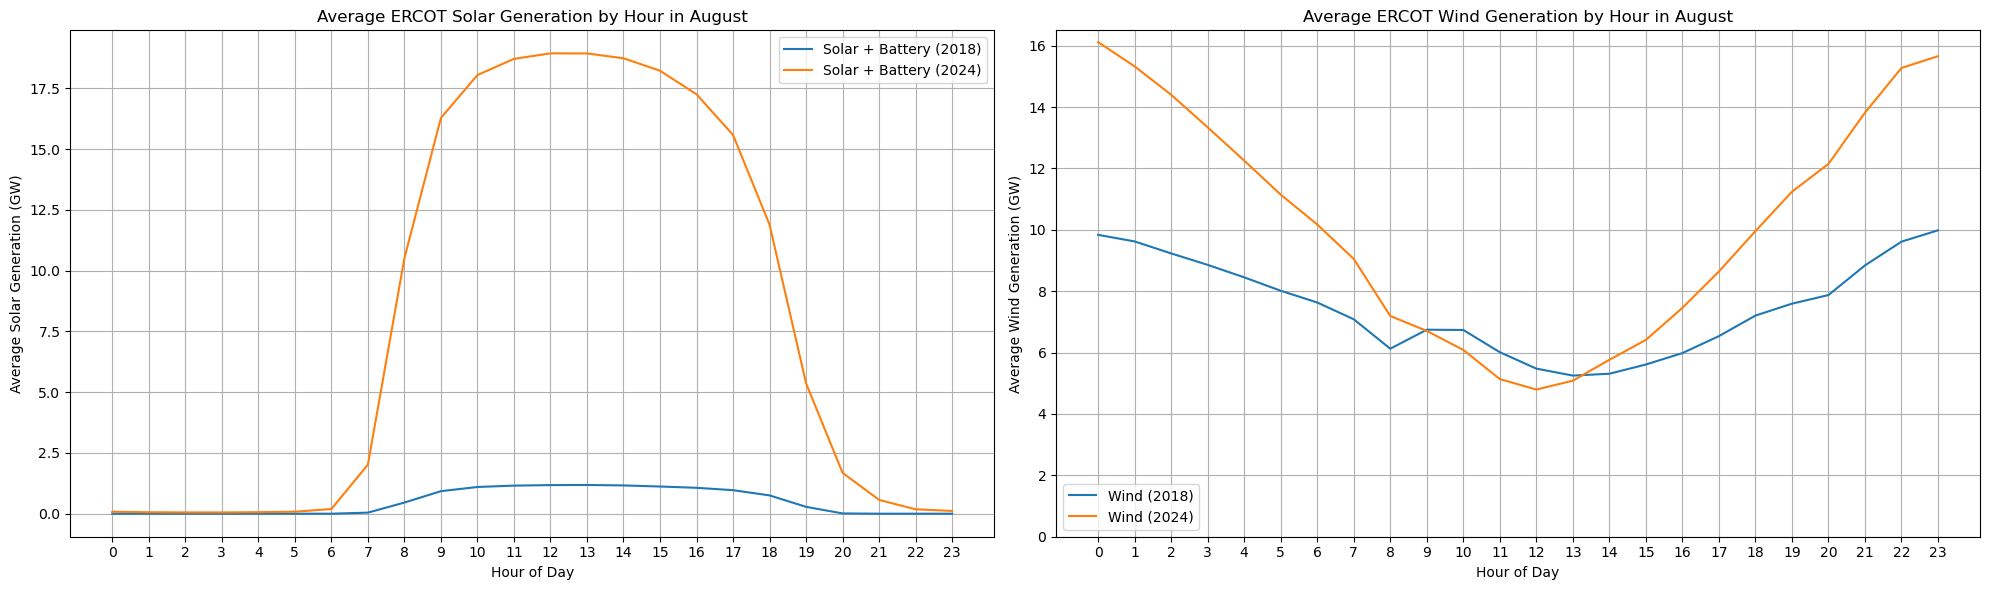

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Solar panel (left)
for year, df in avg_data_by_hour.items():
    if year in ['2018', '2024']:
        x1 = (df['fuel_mix.solar']+df['fuel_mix.power_storage'])/1e3
        ax1.plot(df.index, x1, label=f'Solar + Battery ({year})')

ax1.set_title('Average ERCOT Solar Generation by Hour in August')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Solar Generation (GW)')
ax1.set_xticks(range(0, 24))
ax1.grid(True)
ax1.legend()

# Wind panel (right)
for year, df in avg_data_by_hour.items():
    if year in ['2018', '2024']:
        wind_gw = df['fuel_mix.wind'] / 1e3
        ax2.plot(df.index, wind_gw, label=f'Wind ({year})')

ax2.set_title('Average ERCOT Wind Generation by Hour in August')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Average Wind Generation (GW)')
ax2.set_xticks(range(0, 24))
ax2.grid(True)
ax2.legend()
ax2.set_ylim(0, 16.5)

plt.tight_layout()
plt.savefig('ercot_solar_wind_generation_august.png', dpi=300)
plt.show()

/var/folders/hp/g2_ld8qx627b8pyd2ph0qvf00000gr/T/ipykernel_75635/1157906828.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_spp_by_bin = df.groupby('net_load_bin')['price'].median().reset_index()
/var/folders/hp/g2_ld8qx627b8pyd2ph0qvf00000gr/T/ipykernel_75635/1157906828.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_spp_by_bin = df.groupby('net_load_bin')['price'].median().reset_index()


Price at 52.41 GW net load for 2018: $33.38/MWh
Price at 42.18 GW net load for 2018: $23.83/MWh
Price at 52.41 GW net load for 2024: $29.48/MWh
Price at 42.18 GW net load for 2024: $17.65/MWh


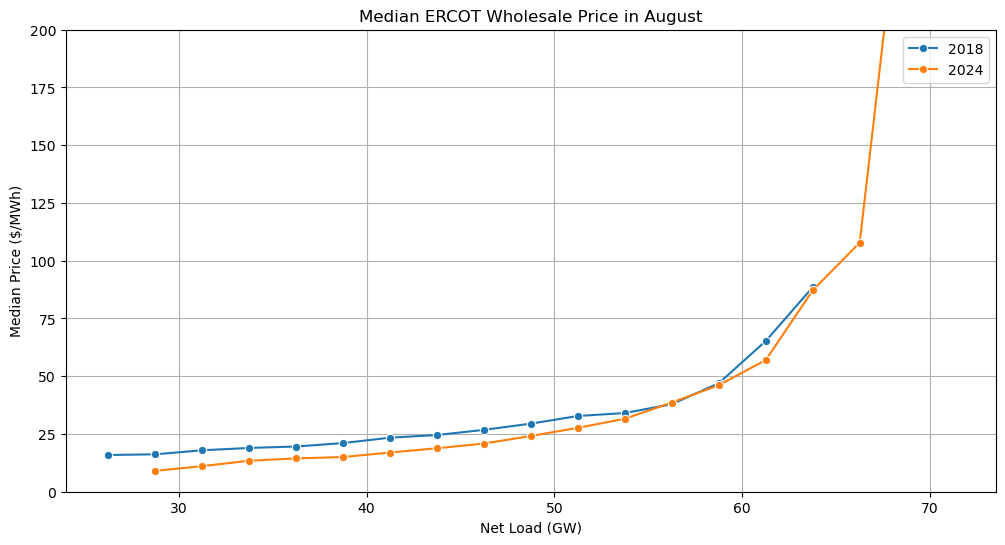

In [6]:
# Define the bin edges based on the range of net_load across all years
all_net_load = pd.concat([df['net_load'] for df in august_dataframes.values()])
min_net_load = all_net_load.min()
max_net_load = all_net_load.max()
bin_width = 2500
bins = np.arange(min_net_load - (min_net_load % bin_width), max_net_load + bin_width, bin_width)

plt.figure(figsize=(12, 6))

years = ['2018', '2024']

for year in years:
    df = august_dataframes[year].copy() # Use a copy to avoid modifying the original dataframe

    # Create bins for net_load and calculate the median spp for each bin
    df['net_load_bin'] = pd.cut(df['net_load'], bins=bins, right=False)
    median_spp_by_bin = df.groupby('net_load_bin')['price'].median().reset_index()

    # Get the midpoint of each bin for plotting
    median_spp_by_bin['net_load_midpoint'] = median_spp_by_bin['net_load_bin'].apply(lambda x: x.mid/1e3)

    # Create interpolation function to get prices at specific net load values
    interp_func = interp1d(median_spp_by_bin['net_load_midpoint'], 
                          median_spp_by_bin['price'], 
                          kind='linear', fill_value='extrapolate')
    
    # Print prices at specified net load values
    price_at_52_41 = interp_func(52.41)
    price_at_42_18 = interp_func(42.18)
    print(f"Price at 52.41 GW net load for {year}: ${price_at_52_41:.2f}/MWh")
    print(f"Price at 42.18 GW net load for {year}: ${price_at_42_18:.2f}/MWh")

    # Plot the median spp against the net load bin midpoints
    sns.lineplot(data=median_spp_by_bin, x='net_load_midpoint', y='price', marker='o', label=f'{year}')

plt.title('Median ERCOT Wholesale Price in August')
plt.xlabel('Net Load (GW)')
plt.ylabel('Median Price ($/MWh)')
plt.grid(True)
plt.legend()
plt.ylim(0,200)
plt.savefig('ercot_price_vs_net_load_august.png', dpi=300)
plt.show()

Cost at 60 GW total demand for 2018: $33.50/MWh
Cost at 60 GW total demand for 2024: $17.12/MWh


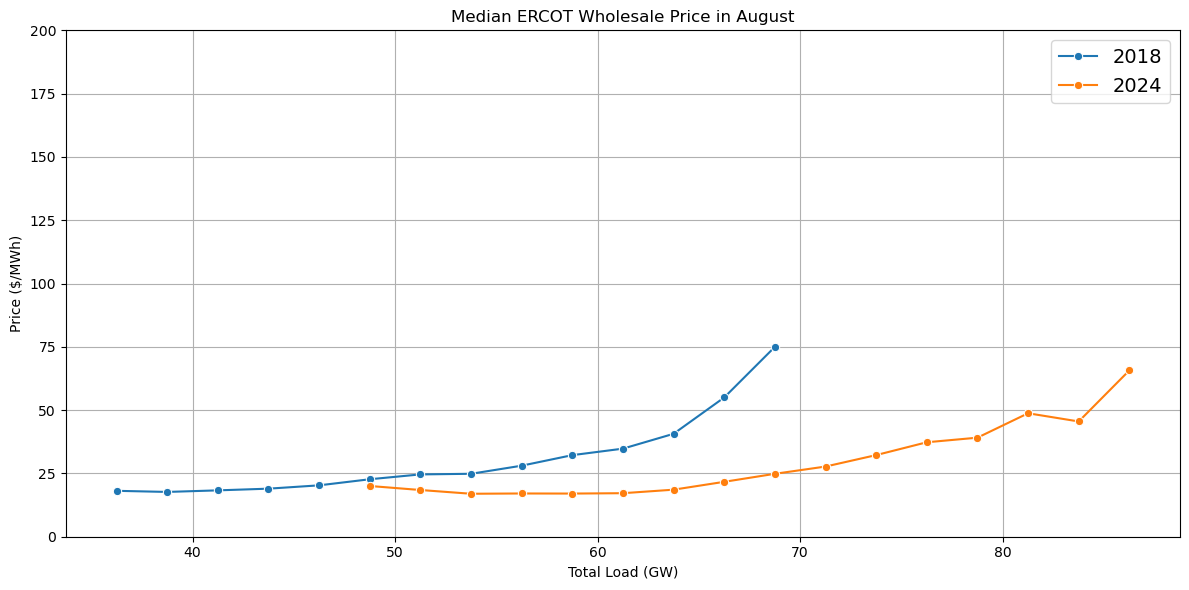

In [7]:
# Define the bin edges based on the range of total load across all years for consistent bins
all_total_load = pd.concat([df['load'] for df in august_dataframes.values()])
min_total_load = all_total_load.min()
max_total_load = all_total_load.max()
bin_width = 2500
bins = np.arange(min_total_load - (min_total_load % bin_width), max_total_load + bin_width, bin_width)

plt.figure(figsize=(12, 6)) # Use a single figure and axes

years = ['2018', '2024']

# Determine the overall x-axis range
total_load_min_overall = all_total_load.min()/1e3
total_load_max_overall = all_total_load.max()/1e3

for year in years:
    df = august_dataframes[year].copy() # Use a copy to avoid modifying the original dataframe

    df['total_load_bin'] = pd.cut(df['load'], bins=bins, right=False)
    mean_spp_by_total_load_bin = df.groupby('total_load_bin', observed=True)['price'].median().reset_index()
    mean_spp_by_total_load_bin['total_load_midpoint'] = mean_spp_by_total_load_bin['total_load_bin'].apply(lambda x: x.mid/1e3)

    # Create interpolation function
    interp_func = interp1d(mean_spp_by_total_load_bin['total_load_midpoint'], 
                          mean_spp_by_total_load_bin['price'], 
                          kind='linear', fill_value='extrapolate')
    
    # Interpolate cost at 60 GW
    cost_at_60gw = interp_func(60.0)
    print(f"Cost at 60 GW total demand for {year}: ${cost_at_60gw:.2f}/MWh")
    
    sns.lineplot(data=mean_spp_by_total_load_bin, x='total_load_midpoint', y='price', marker='o', label=f'{year}') # Plot median lines


plt.title('Median ERCOT Wholesale Price in August')
plt.xlabel('Total Load (GW)')
plt.ylabel('Price ($/MWh)')
plt.grid(True)
plt.legend(prop={'size': 14}) # Increase legend font size
plt.ylim(0, 200)

plt.tight_layout()
plt.savefig('ercot_price_vs_total_load_august.png', dpi=300)
plt.show()

Net load at 60 GW total demand for 2018: 52.41 GW
Net load at 60 GW total demand for 2024: 42.18 GW


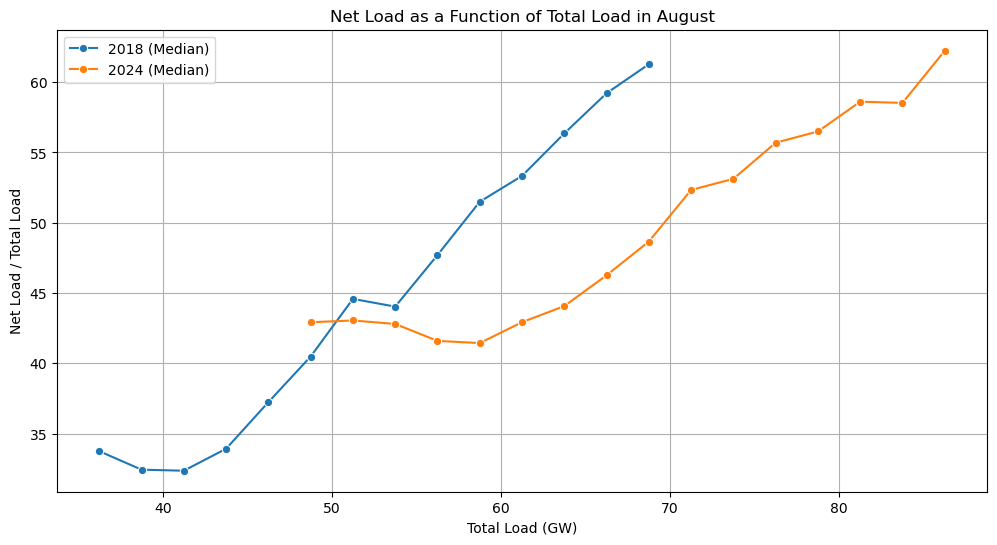

In [8]:
plt.figure(figsize=(12, 6))

years = ['2018', '2024']

# Define the bin edges based on the range of total load across all years for consistent bins
all_total_load = pd.concat([df['load'] for df in august_dataframes.values()])
min_total_load = all_total_load.min()
max_total_load = all_total_load.max()
bin_width = 2500
bins = np.arange(min_total_load - (min_total_load % bin_width), max_total_load + bin_width, bin_width)

for year in years:
    df = august_dataframes[year].copy()
    # Calculate the fraction of net load to total load
    df['net_load_fraction'] = df['net_load']/1e3
    # sns.scatterplot(data=df, x='load.load', y='net_load_fraction', alpha=0.5, label=f'{year} (Hourly Data)')

    # Create bins for total load and calculate the median net_load_fraction for each bin
    df['total_load_bin'] = pd.cut(df['load'], bins=bins, right=False)
    median_fraction_by_bin = df.groupby('total_load_bin', observed=True)['net_load_fraction'].median().reset_index()

    # Get the midpoint of each bin for plotting
    median_fraction_by_bin['total_load_midpoint'] = median_fraction_by_bin['total_load_bin'].apply(lambda x: x.mid/1e3)

    # Create interpolation function
    interp_func = interp1d(median_fraction_by_bin['total_load_midpoint'], 
                          median_fraction_by_bin['net_load_fraction'], 
                          kind='linear', fill_value='extrapolate')
    
    # Interpolate net load at 60 GW
    net_load_at_60gw = interp_func(60.0)
    print(f"Net load at 60 GW total demand for {year}: {net_load_at_60gw:.2f} GW")

    # Plot the median fraction against the total load bin midpoints
    sns.lineplot(data=median_fraction_by_bin, x='total_load_midpoint', y='net_load_fraction', marker='o', label=f'{year} (Median)')


plt.title('Net Load as a Function of Total Load in August')
plt.xlabel('Total Load (GW)')
plt.ylabel('Net Load / Total Load')
plt.grid(True)
plt.legend()
plt.savefig('ercot_net_load_vs_total_load_august.png', dpi=300)
plt.show()